# Convolutional Recurrent Neural Network for Text Recognition

### Imports

In [8]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

### Dataset

In [3]:
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits
 
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [5]:
path = 'mjsynth.tar/mnt/ramdisk/max/90kDICT32px'
 

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
 
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
 
max_label_len = 0
 
i =1 
flag = 0
 
for root, dirnames, filenames in os.walk(path):
 
    for f_name in fnmatch.filter(filenames, '*.jpg'):
        # read input image and convert into gray scale image
        img = cv2.cvtColor(cv2.imread(os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)   
 
        # convert each image of shape (32, 128, 1)
        w, h = img.shape
        if h > 128 or w > 32:
            continue
        if w < 32:
            add_zeros = np.ones((32-w, h))*255
            img = np.concatenate((img, add_zeros))
 
        if h < 128:
            add_zeros = np.ones((32, 128-h))*255
            img = np.concatenate((img, add_zeros), axis=1)
        img = np.expand_dims(img , axis = 2)
        
        # Normalize each image
        img = img/255.
        
        # get the text from the image
        txt = f_name.split('_')[1]
        
        # compute maximum length of the text
        if len(txt) > max_label_len:
            max_label_len = len(txt)
            
           
        # split the 150000 data into validation and training dataset as 10% and 90% respectively
        if i%10 == 0:     
            valid_orig_txt.append(txt)   
            valid_label_length.append(len(txt))
            valid_input_length.append(31)
            valid_img.append(img)
            valid_txt.append(encode_to_labels(txt))
        else:
            orig_txt.append(txt)   
            train_label_length.append(len(txt))
            train_input_length.append(31)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt)) 
        
        # break the loop if total data is 150000
        if i == 150000:
            flag = 1
            break
        i+=1
    if flag == 1:
        break

In [6]:
# pad each output label to maximum text length
 
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

### Network Archtecture

In [4]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [5]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        590080

### Loss Function

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

### train the Model

In [10]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [11]:
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [ ]:
batch_size = 256
epochs = 10
model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

### Pretrained - Use the weights

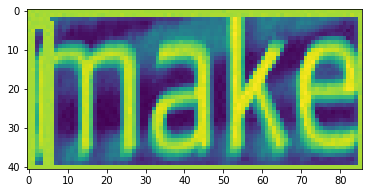

[[ 8 12  0 10  4]]
imake



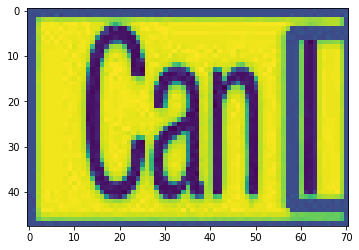

[[28  0 13 11]]
Canl



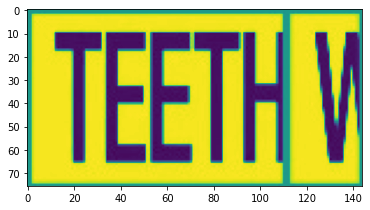

[[45 30 30 45 33 48]]
TEETHW



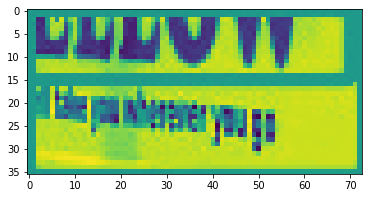

[[45  0  6]]
Tag



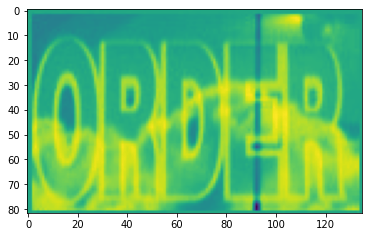

[[40 11 14 11 14 18 11 18]]
Ololosls



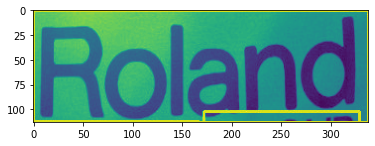

[[43 14 11  0 13  3]]
Roland



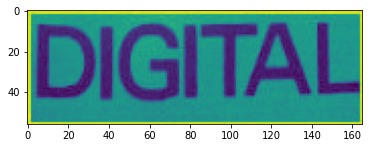

[[29 34 32 34 45 26 37]]
DIGITAL



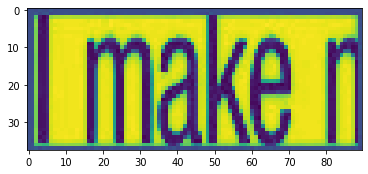

[[34 12  0 10  4 13]]
Imaken



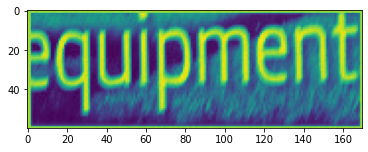

[[16 20 15 12  4 13 19]]
qupment



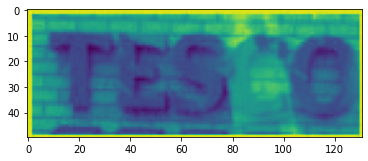

[[27  0 18  4]]
Base



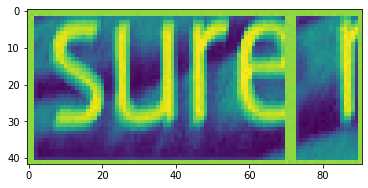

[[44 37 34 30 29]]
SLIED



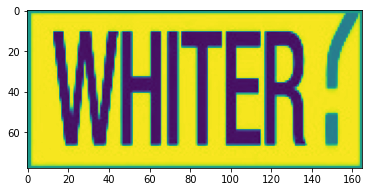

[[48 33 34 45 30 43 30]]
WHITERE



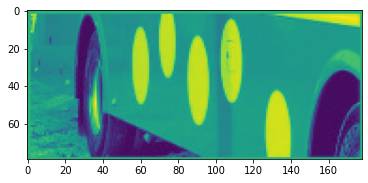

[[26 14 14 14 13  2]]
Aooonc



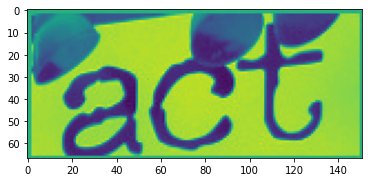

[[ 0  2 19]]
act



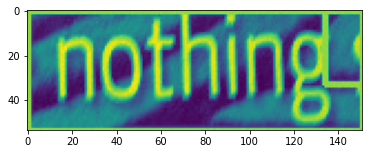

[[39 14 19  7  8 13  6  6]]
Nothingg



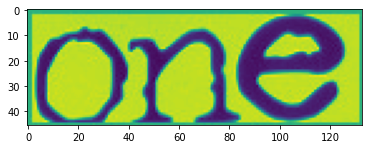

[[40 16  4]]
Oqe



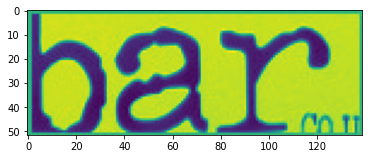

[[ 1  0 13]]
ban



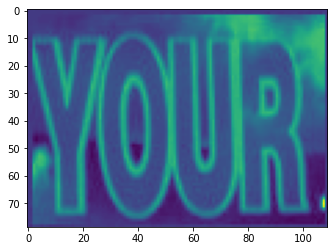

[[50 40 46 43 34]]
YOURI



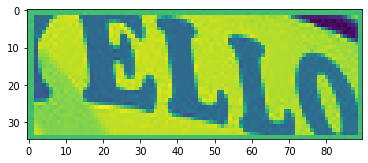

[[31 30 37 34 32]]
FELIG



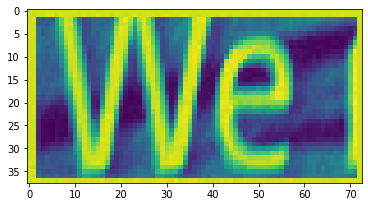

[[ 1 21  0 21  4 18]]
bvaves



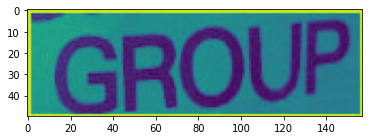

[[32 32 43 40 46 41]]
GGROUP



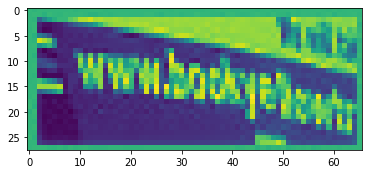

[[31 20  4 20 17  0 18 15  8 18 18]]
Fueuraspiss



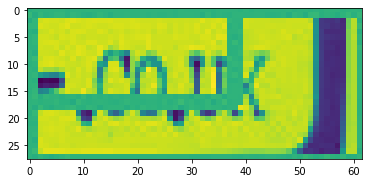

[[27 28 40 46 10  3]]
BCOUkd



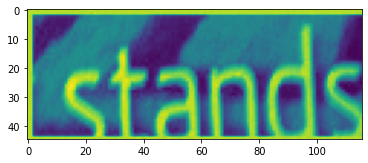

[[45 19  0  3 18]]
Ttads



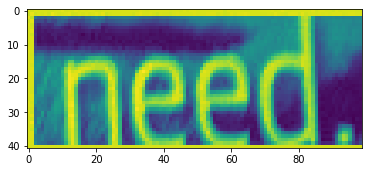

[[12  4  2  3  3]]
mecdd



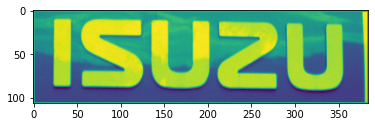

[[34 44 20 20]]
ISuu



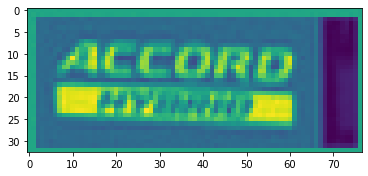

[[30 18 18  0 17  4 17]]
Essarer



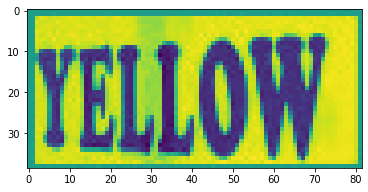

[[50 30 37 37 40 48]]
YELLOW



In [26]:
path = r'C:\Users\mn_aj\Python_Refresher\Cap_stone\Task1\functional_api\Text-Detection-using-Yolo-Algorithm-in-keras-tensorflow-master\Results2'
for i in os.listdir(path):
    imgb = cv2.cvtColor(cv2.imread(os.path.join(path,i)), cv2.COLOR_BGR2GRAY)
    img = cv2.resize(imgb,(128, 32))
    img = np.expand_dims(img , axis = 0)
        
        # Normalize each image
    img = img/255.
    plt.imshow(imgb)
    plt.show()
    act_model.load_weights('crnn_model.h5')

    valid_img = np.array(img)
# predict outputs on validation images
    prediction = act_model.predict(valid_img)

# use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
    print(out)
# see the results
    i = 0
    for x in out:
        for p in x:  
            if int(p) != -1:
                print(char_list[int(p)], end = '')       
        print('\n')
        i+=1